In [1]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
with open('order_dict.json') as f:
    data = json.load(f)
with open('capstone_jd_msom_data-minus-click-data/warehouse_capacity.json') as f2:
    warehouse_capacity = json.load(f2)

In [10]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}
capacity = {int(k):v[1] for k, v in warehouse_capacity.items()}

In [13]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [14]:
def r2_loss(outputs, targets):
    target_mean = torch.mean(targets)
    ss_tot = torch.sum((targets - target_mean) ** 2)
    ss_res = torch.sum((targets - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def r2_loss_2(outputs, targets):
    ss_tot = 0.0
    ss_res = 0.0
    target_mean = torch.mean(targets)
    for i in range(0,len(outputs)):
        ss_tot += (targets[i] - target_mean) ** 2
        ss_res += (targets[i] - outputs[i]) ** 2
    r2 = 1 - ss_res / ss_tot
    return r2

# TODO: need to work with tensor objects.
def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = capacity_i / 31
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost

def SPO_MSE_Loss(d_pred, d_actual):
    spo_loss = SPOLoss(d_pred, d_actual)
    mse_loss = 0.0
    for i in range(0, len(d_pred)):
        mse_loss += (d_pred[i] - d_actual[i]) ** 2
    mse_loss = mse_loss / len(d_pred)
    # mse_loss = sum((d_pred - d_actual) ** 2) / len(d_pred)    # don't use this, because d_pred can is 1*N dimention but d_actual can be N*1 dimension
    return spo_loss + 0.1 * mse_loss

In [15]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [16]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    elif loss_type == 'SPO_MSE': # change loss function and switch to adam optimizer
        
        criterion = SPO_MSE_Loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(epochs),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO Loss/day': SPO_mean})
    

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [23]:
#import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    # return the best penalty coefficient that minimize average validation error
    
    #start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 301
        grid = np.linspace(0,1,11) if regularize == 'l2' else np.linspace(0,5,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 301
        grid = np.linspace(0,5,6) if regularize == 'l2' else np.linspace(0,10,6)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(aveloss.keys(), aveloss.values())
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    #print('The best penalty coefficient is '+ str(best))
    
    #stop = timeit.default_timer()
    #print('Time: ', stop - start)  
    return best

# Model Training

In [25]:
def model_pipeline(x_train, y_train, x_test, y_test):
    # MSE loss models
    learningRate = 0.02
    epochs = 501

    # ols model training
    model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None', plot = False, verbose = False)


    # ridge regression (l2 regrularization)
    best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2', plot = True)
    model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2, plot = False, verbose = False)

    # l1 regularization (lasso)
    best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1', plot = True)
    model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1, plot = False, verbose = False)

    # compile results for models trained on MSE loss
    MSE_result = []

    for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
        score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
        MSE_result.append(pd.concat({name:score_df}))

    MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])

    # SPO loss models
    learningRate = 0.02
    epochs = 1001

    # ols model
    model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None', plot = False, verbose = False)

    # ridge regression
    #best_l2_spo = cross_validate(x_train, y_train, 'SPO', 'l2', plot = False)
    model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = best_l2, plot = False, verbose = False)

    # lasso regression
    #best_l1_spo = cross_validate(x_train, y_train, 'SPO', 'l1', plot = False)
    model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = best_l1, plot = False, verbose = False)

    # compile results for models trained on SPO loss
    SPO_result = []

    for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
        score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
        SPO_result.append(pd.concat({name:score_df}))

    SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])

    return MSE_scores, SPO_scores

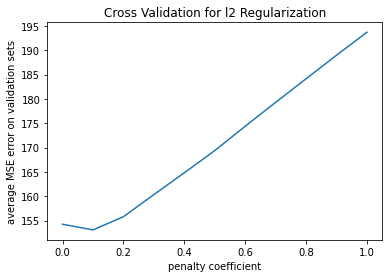

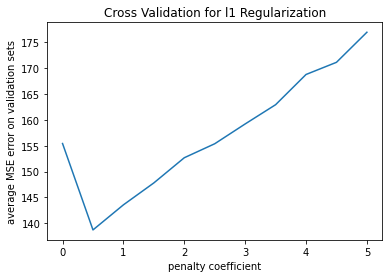

(                       MSE       R^2     SPO Loss  SPO Loss/day
 mse_ols   train  58.011622  0.763867  2057.570478     10.391770
           test   65.433599  0.595828   645.863262     11.330934
 mse_ridge train  60.255712  0.754732  1928.747810      9.741151
           test   61.488374  0.620197   580.349433     10.181569
 mse_lasso train  62.463805  0.745744  2081.911620     10.514705
           test   57.665336  0.643811   576.524845     10.114471,
                         MSE       R^2     SPO Loss  SPO Loss/day
 spo_ols   train  148.567024  0.395265  1088.770742      5.498842
           test    98.866981  0.389316   405.380178      7.111933
 spo_ridge train  148.652208  0.394918  1088.556953      5.497762
           test    98.417278  0.392093   404.117467      7.089780
 spo_lasso train  148.843883  0.394138  1088.621779      5.498090
           test    98.419491  0.392080   403.397205      7.077144)

In [26]:
%%script echo skipping
i = 1
x_train, y_train, x_test, y_test = preprocessing(order_dict[i])
capacity_i = capacity[i] if i in capacity.keys() else pd.Series(capacity).mean()
model_pipeline(x_train, y_train, x_test, y_test)

In [27]:
final_results = dict()
for dc_i in order_dict.keys():
    x_train, y_train, x_test, y_test = preprocessing(order_dict[dc_i])  
    capacity_i = capacity[dc_i]
    MSE_i, SPO_i = model_pipeline(x_train, y_train, x_test, y_test)
    final_results[dc_i] = {'MSE result': MSE_i, 'SPO result': SPO_i}
    print(str(dc_i)+' done.')

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [38]:
#final_results.values()

dict_values([{'MSE result':                        MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train  57.967809  0.764045  2050.622227     10.356678
          test   65.624006  0.594652   644.375270     11.304829
mse_ridge train  60.253760  0.754740  1925.947224      9.727006
          test   61.553501  0.619795   577.760973     10.136157
mse_lasso train  60.103433  0.755352  2045.648604     10.331559
          test   60.268742  0.627730   595.920618     10.454748, 'SPO result':                         MSE       R^2     SPO Loss  SPO Loss Ave
spo_ols   train  148.938473  0.393753  1089.376335      5.501901
          test    98.641693  0.390707   404.980823      7.104927
spo_ridge train  149.506349  0.391442  1089.250094      5.501263
          test    98.686273  0.390432   404.573871      7.097787
spo_lasso train  149.410933  0.391830  1089.651600      5.503291
          test    98.578287  0.391099   404.565691      7.097644}, {'MSE result':                           MSE       R

In [ ]:
#%%script echo skipping

#final_results_json = {int(k): {k2: v2.to_dict() for k2, v2 in v.items()} for k, v in final_results.items()}
final_results_capacity = {int(k): {k2: {k3: {'_'.join(k4):v4 for k4, v4 in v3.items()} 
                                     for k3, v3 in v2.items()} 
                                for k2, v2 in v.items()}  
                       for k, v in final_results.items()}

with open('final_results_capacity.json','w') as f:
    json.dump(final_results_capacity, f)

In [17]:
MSE_columns, MSE_index = final_results[1]['MSE result'].columns, final_results[1]['MSE result'].index
SPO_columns, SPO_index = final_results[1]['SPO result'].columns, final_results[1]['SPO result'].index

In [18]:
final_mse_ave = sum([results['MSE result'].to_numpy() for results in final_results.values()])/len(final_results)

pd.DataFrame(final_mse_ave, columns = MSE_columns, index = MSE_index)

MSE       R^2     SPO Loss  SPO Loss/day
mse_ols   train  2946.844356  0.653827  8559.496875     37.711678
          test   2609.917293  0.511161  2183.649553     33.827877
mse_ridge train  3053.790541  0.638025  8056.839947     35.416656
          test   2638.812466  0.533993  2053.184788     31.723890
mse_lasso train  2968.989704  0.628058  8499.616465     37.449544
          test   2581.486469  0.563421  2127.440674     32.879025

In [19]:
final_spo_ave = sum([results['SPO result'].to_numpy() for results in final_results.values()])/len(final_results)

pd.DataFrame(final_spo_ave, columns = SPO_columns, index = SPO_index)

MSE       R^2     SPO Loss  SPO Loss/day
spo_ols   train  14247.575901  0.170721  7002.118628     30.434856
          test   14688.115174  0.046192  2564.962021     39.250792
spo_ridge train  15216.562925  0.068993  7457.814363     32.417654
          test   15932.817883 -0.078750  2694.691782     41.232807
spo_lasso train  14703.616950  0.119094  7119.002330     30.955686
          test   15247.038752 -0.005499  2585.240556     39.544916

In [21]:
spo_loss_ave = {dc: results['SPO result'].loc[('spo_lasso','test'), 'SPO Loss/day'] for dc, results in final_results.items()}
mse_loss_ave = {dc: results['MSE result'].loc[('mse_lasso','test'), 'SPO Loss/day'] for dc, results in final_results.items()}

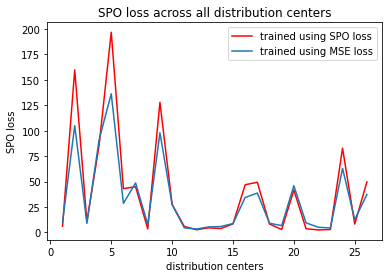

In [31]:
plt.plot(pd.Series(spo_loss_ave), color = 'red', label = 'trained using SPO loss')
plt.plot(pd.Series(mse_loss_ave), label = 'trained using MSE loss')
plt.ylabel('SPO loss')
plt.xlabel('distribution centers')
plt.legend(loc = 'upper right')
plt.title('SPO loss across all distribution centers')
plt.show()

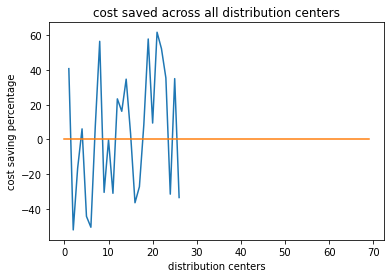

In [32]:
cost_saved_percent = (1- pd.Series(spo_loss_ave) / pd.Series(mse_loss_ave))*100
plt.plot(cost_saved_percent)
plt.ylabel('cost saving percentage')
plt.xlabel('distribution centers')
plt.title('cost saved across all distribution centers')
plt.plot(np.repeat(0,70))
plt.show()

In [33]:
cost_saved_percent

1     40.776624
2    -52.239177
3    -16.586056
4      6.040602
5    -44.423814
6    -50.692329
7      7.663011
8     56.537775
9    -30.585021
10    -0.313055
11   -31.119267
12    23.350441
13    16.191657
14    34.715195
15     3.246704
16   -36.566863
17   -27.329277
18     8.399076
19    57.885951
20     9.400304
21    61.776749
22    52.296241
23    35.443530
24   -31.606522
25    35.028552
26   -33.549324
dtype: float64

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
